# Nenana Ice Classic - Model Stacking

In [44]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mlxtend.plotting import plot_decision_regions

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OneHotEncoder
from sklearn.decomposition import KernelPCA as KPCA
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

# models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # metrics I used

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

rng = np.random.RandomState(42)

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [3]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
#         self.ohe.fit(self.forest.apply(X)[:,:,0])
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
#         return self.ohe.transform(self.forest.apply(X)[:,:,0])
        return self.ohe.transform(self.forest.apply(X))


In [4]:
df = pd.read_csv('../data/features_added.csv')

In [5]:
df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,0.0,0.0,...,0.714286,1.30384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

#### How good does my model have to be?

In [6]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

#### Drop columns that are highly correlated
* temperatureMin and temperatureMax information was captured in temperatureAvg
* precipAccumulation information was captured in accumulatedSnow

In [7]:
df.drop(columns = ['temperatureMin', 'temperatureMax', 'precipAccumulation'],
        inplace = True)

#### Create training and testing DataFrames

In [8]:
train = df.loc[df['past'] == 1]
train.drop(columns = ['past', 'future'], inplace = True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 1398
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.7+ MB


In [10]:
test = df.loc[df['future'] == 1]
test.drop(columns = ['past', 'future'], inplace = True)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 1399 to 1676
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 354.0+ KB


In [12]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

11

In [13]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [14]:
used_cols = [c for c in train.columns if c not in exclude]

In [15]:
no_ma_cols = [c for c in df.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [16]:
pprint.pprint(no_ma_cols)
pprint.pprint(used_no_ma_cols)

['Date',
 'moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'winningTime',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'winningDate',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']
['moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']


In [17]:
train.dropna(inplace = True)

In [18]:
test.dropna(inplace = True)

In [19]:
target = 'winningDate'

In [20]:
gc.collect()

0

* model stacking: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

---
### Model Stacking

#### Stacked Model Using LogReg Meta-Classifier

In [21]:
# using logreg for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca5 = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state=42,
                                          learning_rate=0.03,
                                          max_iter=225,
                                          max_leaf_nodes=2**2-1,
                                          max_bins=150,
                                          l2_regularization=0.82)

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (2, 6, 7, 8, 11, 23, 14)),
                              scaler, binner, objectify, encoder, clf_lr)

lr_pipe5 = make_pipeline(scaler, binner, objectify, encoder, pca5, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)),
                              scaler, clf_svc)

sclf = StackingCVClassifier(classifiers=[lr_pipe_no_ma, lr_pipe5, svm_pipe_no_ma, clf_tree], 
                            meta_classifier=clf_lr,
                            random_state=42)

scores = cross_validate(sclf, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1', 'f1_weighted', 'precision', 'precision_weighted',
                                 'recall', 'recall_weighted', 'accuracy', 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1: nan +/- nan
f1_weighted: nan +/- nan
precision: nan +/- nan
precision_weighted: nan +/- nan
recall: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [22]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(2, 6, 7,
                                                                        8, 11,
                                                                        23,
                                                                        14),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
                                                                with_centering=True,
                                                                with_scaling=

In [23]:
y_train_preds = sclf.predict(X_train)

In [24]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[983, 176],
       [  0,  24]])

In [25]:
X_test = test[used_cols]
y_test = test[target]
y_pred = sclf.predict(X_test)

In [26]:
metrics.confusion_matrix(y_test, y_pred)

array([[198,  30],
       [  1,   4]])

In [27]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8669527896995708
Test set balanced_accuracy: 0.8342105263157895


lorem ipsum

In [28]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.06554374, 0.06554374, 0.06554374, 0.06554374, 0.06554374])

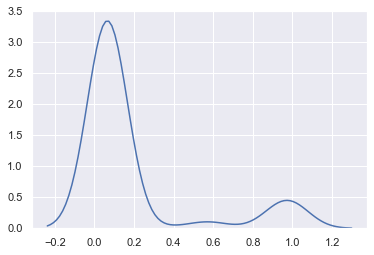

In [29]:
sns.kdeplot(y_pred);

In [30]:
metrics.confusion_matrix(y_test, y_pred > 0.0656)

array([[197,  31],
       [  1,   4]])

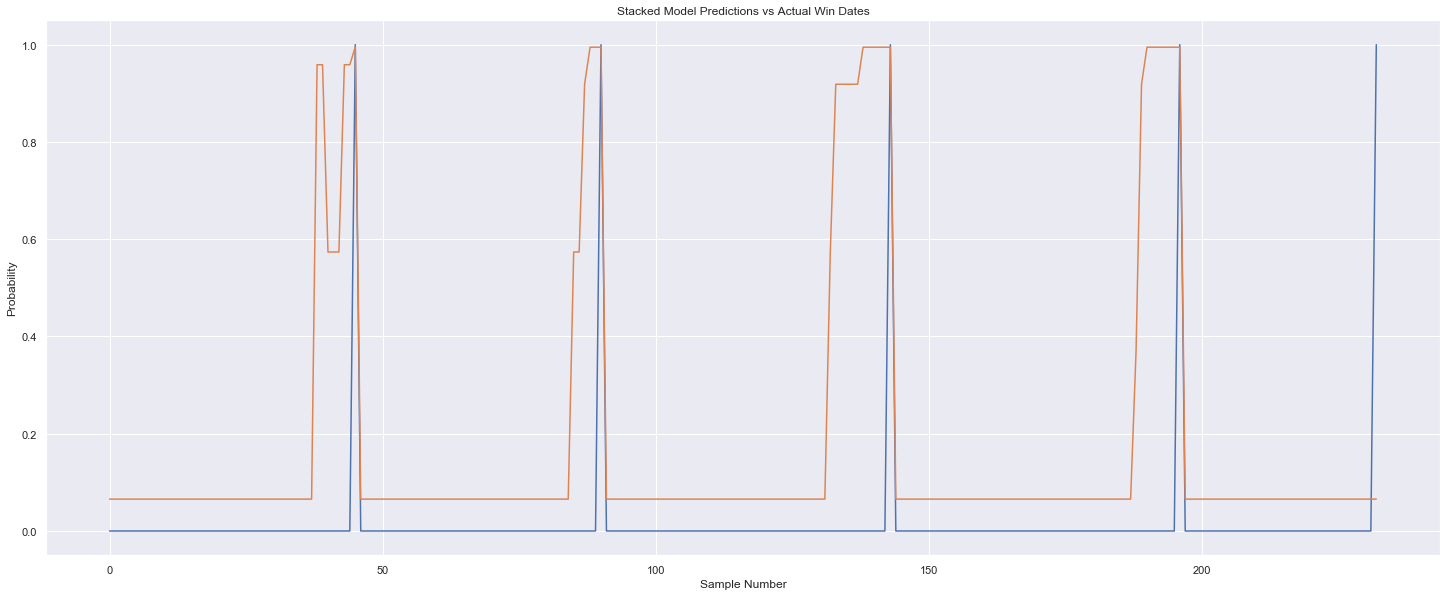

In [31]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

#### Stacked Model Using SVM Meta-Classifier

In [32]:
# using SVM for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca5 = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state=42,
                                          learning_rate=0.03,
                                          max_iter=225,
                                          max_leaf_nodes=2**2-1,
                                          max_bins=150,
                                          l2_regularization=0.82)

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (2, 6, 7, 8, 11, 23, 14)),
                              scaler, binner, objectify, encoder, clf_lr)

lr_pipe5 = make_pipeline(scaler, binner, objectify, encoder, pca5, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)),
                              scaler, clf_svc)

sclf = StackingCVClassifier(classifiers=[lr_pipe_no_ma, lr_pipe5, svm_pipe_no_ma, clf_tree], 
                            meta_classifier=clf_svc,
                            random_state=42)

In [33]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(2, 6, 7,
                                                                        8, 11,
                                                                        23,
                                                                        14),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
                                                                with_centering=True,
                                                                with_scaling=

In [34]:
y_train_preds = sclf.predict(X_train)

In [35]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[983, 176],
       [  2,  22]])

In [36]:
X_test = test[used_cols]
y_test = test[target]
# y_pred = sclf.predict_proba(X_test)[:,1] > 0.0525
y_pred = sclf.predict(X_test)

In [37]:
metrics.confusion_matrix(y_test, y_pred)

array([[198,  30],
       [  1,   4]])

In [38]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8669527896995708
Test set balanced_accuracy: 0.8342105263157895


lorem ipsum

In [39]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00820873, 0.00820873, 0.00820873, 0.00820873, 0.00820873])

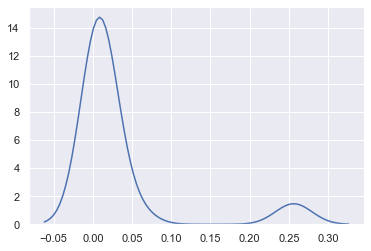

In [40]:
sns.kdeplot(y_pred);

In [41]:
metrics.confusion_matrix(y_test, y_pred > 0.0656)

array([[211,  17],
       [  2,   3]])

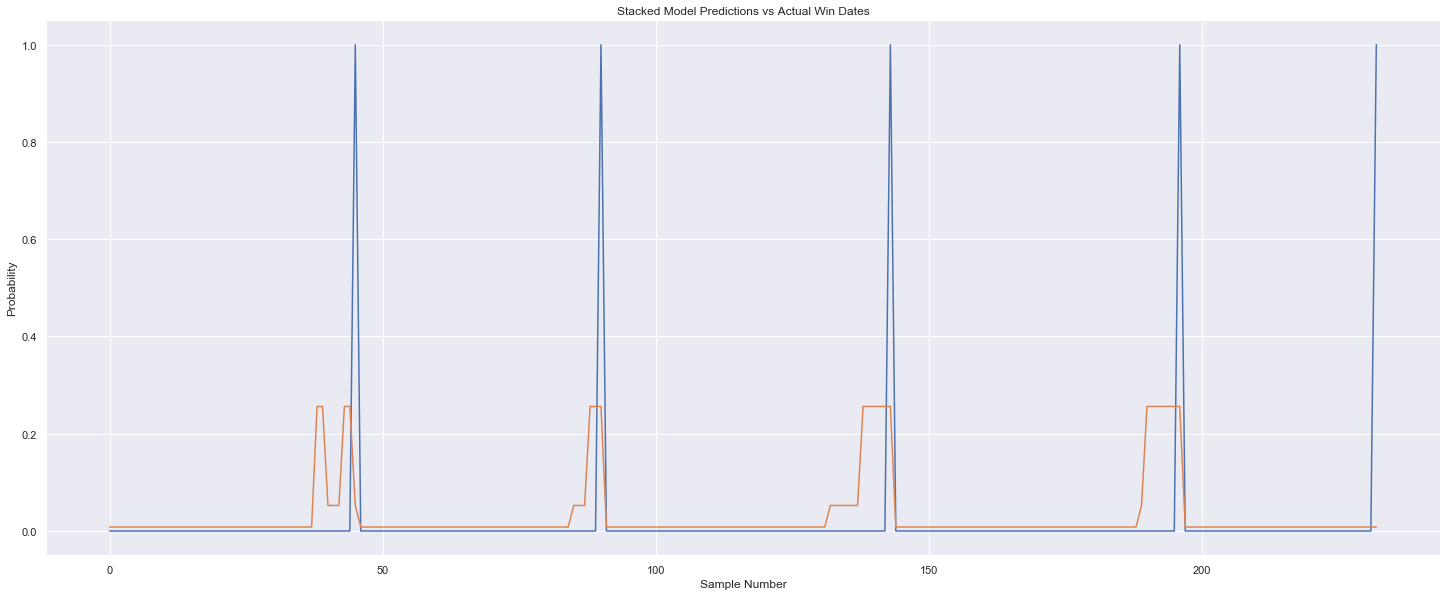

In [42]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

#### Stacked Model Using Random Forest w/LogReg Meta-Classifier

In [56]:
# using logreg random forest for meta-classifier
X_train, y_train = train[used_cols].values, train[target].values
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins = 7, encode = 'ordinal')
objectify = FunctionTransformer(func = stringify, check_inverse = False, validate = False)
encoder = WOEEncoder()
pca5 = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

rf = RandomForestClassifier(bootstrap = True,
                            class_weight = 'balanced',
                            criterion = 'entropy',
                            max_depth = 6,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 60,
                            n_jobs = -1, random_state = 42)

rf_encoder = ForestEncoder(rf)

clf_lr_meta = LogisticRegressionCV(class_weight = 'balanced',
                                   cv = TimeSeriesSplit(),
                                   solver = 'liblinear',
                                   n_jobs = -1,
                                   random_state = 42,
                                   scoring = 'recall')

clf_lr = LogisticRegressionCV(class_weight = 'balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs = -1,
                              random_state = 42)

clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight = 'balanced',
              random_state = 42, probability = True)

clf_tree = HistGradientBoostingClassifier(loss='auto',
                                          random_state = 42,
                                          learning_rate = 0.03,
                                          max_iter = 225,
                                          max_leaf_nodes = 2**2-1,
                                          max_bins = 150,
                                          l2_regularization = 0.82)

lr_pipe_no_ma = make_pipeline(ColumnSelector(cols = (2, 6, 7, 8, 11, 23, 14)),
                              scaler, binner, objectify, encoder, clf_lr)

lr_pipe5 = make_pipeline(scaler, binner, objectify, encoder, pca5, clf_lr)

svm_pipe_no_ma = make_pipeline(ColumnSelector(cols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)),
                              scaler, clf_svc)

meta_pipe = make_pipeline(rf_encoder, clf_lr_meta)

sclf = StackingCVClassifier(classifiers = [lr_pipe_no_ma, lr_pipe5, svm_pipe_no_ma, clf_tree], 
                            meta_classifier = meta_pipe,
                            random_state = 42)

In [57]:
sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('columnselector',
                                                   ColumnSelector(cols=(2, 6, 7,
                                                                        8, 11,
                                                                        23,
                                                                        14),
                                                                  drop_axis=False)),
                                                  ('robustscaler',
                                                   RobustScaler(copy=True,
                                                                quantile_range=(25.0,
                                                                                75.0),
                                                                with_centering=True,
                                                                with_scaling=

In [58]:
y_train_preds = sclf.predict(X_train)

In [59]:
metrics.confusion_matrix(y_train, y_train_preds)

array([[1002,  157],
       [   0,   24]])

In [60]:
X_test = test[used_cols]
y_test = test[target]
# y_pred = sclf.predict_proba(X_test)[:,1] > 0.0525
y_pred = sclf.predict(X_test)

In [61]:
metrics.confusion_matrix(y_test, y_pred)

array([[198,  30],
       [  1,   4]])

In [62]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8669527896995708
Test set balanced_accuracy: 0.8342105263157895


lorem ipsum

In [63]:
y_pred = sclf.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.30280218, 0.30280218, 0.30280218, 0.30280218, 0.30280218])

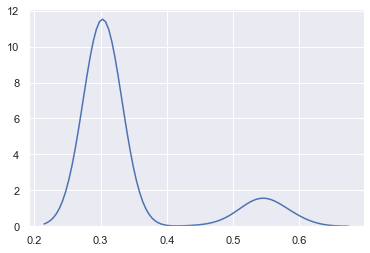

In [64]:
sns.kdeplot(y_pred);

In [65]:
metrics.confusion_matrix(y_test, y_pred > 0.0656)

array([[  0, 228],
       [  0,   5]])

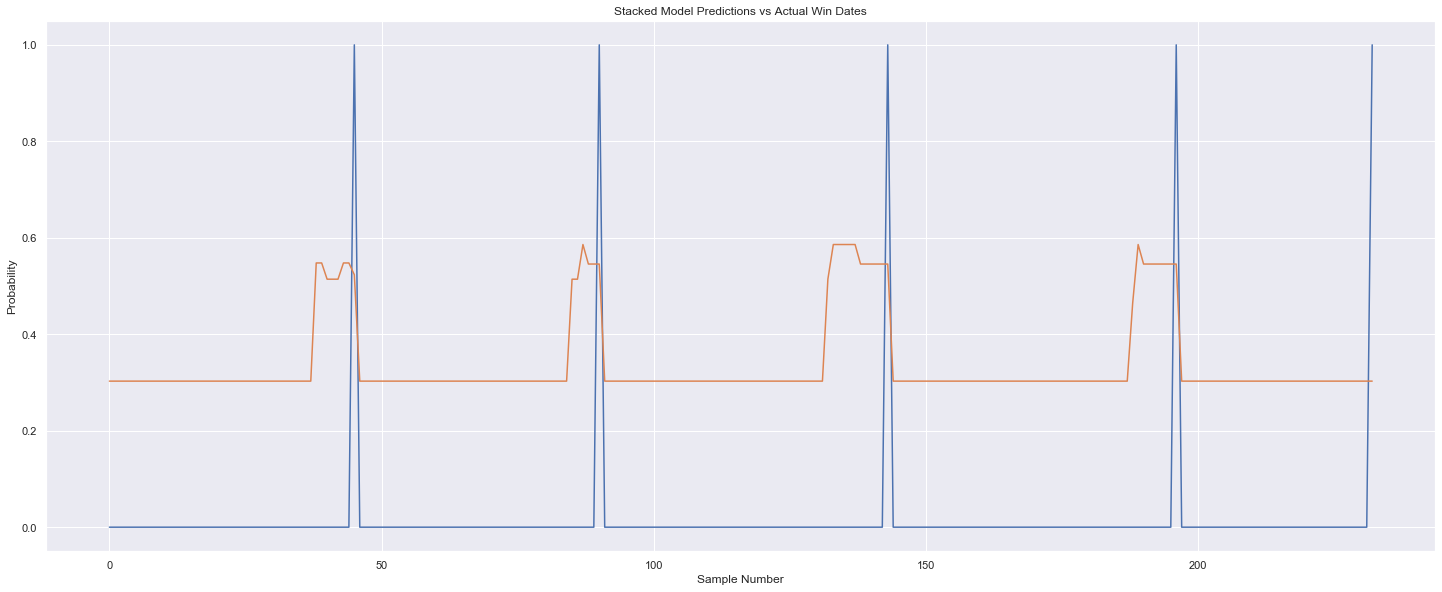

In [66]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Stacked Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()